In [1]:
import gzip
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from PIL import Image
import os
import shutil
import json
import io

# Inspect full image archive without extracting all files

In [2]:
%%time
_pwd = b'2019Deepfashion2**'
zipf = zipfile.ZipFile('train.zip')

CPU times: user 2.89 s, sys: 112 ms, total: 3 s
Wall time: 3 s


In [3]:
filenames = zipf.namelist()
df = pd.DataFrame([x.split('/') for x in filenames[:]], columns=['root_path', 'folder', 'filename'])
df['path'] = filenames

In [4]:
df = df.dropna()
df = df[df.filename != '']
df = df.reset_index()
print(len(df))
df.sample(n=5)

383922


,index,root_path,folder,filename,path
128322,128324,train,annos,063646.json,train/annos/063646.json
17784,17786,train,annos,131968.json,train/annos/131968.json
306975,306978,train,image,000675.jpg,train/image/000675.jpg
209362,209365,train,image,056899.jpg,train/image/056899.jpg
163983,163985,train,annos,016871.json,train/annos/016871.json


In [5]:
osize = 0 
for item in zipf.infolist():
    osize += item.file_size
print('uncompressed size =',round(osize/1000000000,2),'GB')

uncompressed size = 10.89 GB


# Basic EDA


In [6]:
samples = df[df['folder']=='image']['path'].sample(10)

In [7]:
samples

278109    train/image/049604.jpg
335696    train/image/120200.jpg
259038    train/image/036440.jpg
197627    train/image/138243.jpg
345694    train/image/164659.jpg
200537    train/image/135795.jpg
231396    train/image/106162.jpg
341304    train/image/056734.jpg
203911    train/image/188843.jpg
261090    train/image/047905.jpg
Name: path, dtype: object

In [8]:
samples = df[df['folder']=='image']['path'].sample(10)
annos = []
bboxes = []
images = []
for file in samples[:1]: 
    anno = zipf.read(file.replace('.jpg','.json').replace('/image/','/annos/'), pwd=_pwd)
    anno = json.loads(str(anno)[2:-1])
    annos.append(anno)
    
    bbox = anno['item1']['bounding_box']
    bboxes.append(bbox)
    
    img = Image.open(io.BytesIO(zipf.read(file, pwd=_pwd)))
    images.append(img)

In [9]:
annos = []
bboxes = []
images = []
for file in samples[:1]: 
    anno = zipf.read(file.replace('.jpg','.json').replace('/image/','/annos/'), pwd=_pwd)
    anno = json.loads(str(anno)[2:-1])
    annos.append(anno)
    
    bbox = anno['item1']['bounding_box']
    bboxes.append(bbox)
    
    img = Image.open(io.BytesIO(zipf.read(file, pwd=_pwd)))
    images.append(img)

In [10]:
#anno['item1'].keys()
#dict_keys(['segmentation', 'scale', 'viewpoint', 'zoom_in', 'landmarks', 'style', 'bounding_box', 'category_id', 'occlusion', 'category_name'])

### Inspect a few sample images and corresponding bounding boxes

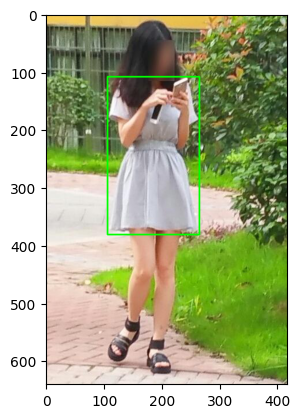

In [12]:
for img, bbox in zip(images, bboxes):
    (x1, y1, x2, y2) = bbox
    img_bbox = cv2.rectangle(np.array(img), (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.imshow(img_bbox)
    plt.show()

# Examine classes

In [13]:
%%time

ids = []
sources = []
scales = []
viewpoints = []
zooms = []
occlusions = []
landmarks = []
bboxes = []
styles = []
category_ids = []
category_names = []
annos = df[df['folder']=='annos']
print('# rows', len(annos))
for idx, row in tqdm(annos.iterrows()): 
    file = row.path
    anno = zipf.read(file, pwd=_pwd)
    anno = json.loads(str(anno)[2:-1])
    
    for key in anno.keys():
        if 'item' in key:
            ids.append(row.filename.split('.')[0])
            sources.append(anno['source'])
            #anno.keys() => dict_keys(['segmentation', 'scale', 'viewpoint', 'zoom_in', 'landmarks', 'style', 'bounding_box', 'category_id', 'occlusion', 'category_name'])
            scales.append(anno[key]['scale'])
            viewpoints.append(anno[key]['viewpoint'])
            zooms.append(anno[key]['zoom_in'])
            occlusions.append(anno[key]['occlusion'])
            landmarks.append(anno[key]['landmarks'])
            bboxes.append(anno[key]['bounding_box'])
            styles.append(anno[key]['style'])
            category_ids.append(anno[key]['category_id'])
            category_names.append(anno[key]['category_name'])    

# rows 191961


0it [00:00, ?it/s]

CPU times: user 2min 22s, sys: 2.07 s, total: 2min 24s
Wall time: 2min 24s


In [14]:
df_meta_all = pd.DataFrame(data=zip(ids, sources, scales, viewpoints, zooms, occlusions, landmarks, bboxes, styles, category_ids, category_names), columns=['id', 'source', 'scale', 'viewpoint', 'zoom', 'occlusion', 'landmarks', 'bbox', 'style', 'category_id', 'category_name'])
print(len(df_meta_all))
df_meta_all[:5]

312186


,id,source,scale,viewpoint,zoom,occlusion,landmarks,bbox,style,category_id,category_name
0,024410,user,3,1,2,1,"[211, 148, 2, 122, 90, 2, 152, 168, 2, 219, 18...","[2, 78, 452, 694]",1,5,vest
1,024334,shop,2,2,1,2,"[317, 114, 1, 242, 134, 2, 280, 170, 2, 363, 1...","[65, 57, 616, 589]",1,1,short sleeve top
2,024334,shop,3,2,1,1,"[391, 261, 1, 310, 288, 2, 347, 288, 2, 395, 2...","[176, 57, 721, 928]",2,13,sling dress
3,024330,user,3,2,2,2,"[271, 68, 1, 0, 0, 0, 187, 54, 2, 257, 109, 2,...","[2, 1, 465, 606]",1,1,short sleeve top
4,024330,user,3,2,2,1,"[226, 115, 1, 92, 63, 2, 169, 99, 2, 223, 124,...","[35, 0, 467, 623]",2,13,sling dress


In [16]:
df_meta = df_meta_all.copy()

## Reference:  https://github.com/switchablenorms/DeepFashion2

Key fields:

- source: a string, where 'shop' indicates that the image is from commercial store while 'user' indicates that the image is taken by users.

- scale: a number, where 1 represents small scale, 2 represents modest scale and 3 represents large scale.

- occlusion: a number, where 1 represents slight occlusion(including no occlusion), 2 represents medium occlusion and 3 represents heavy occlusion.

- zoom_in: a number, where 1 represents no zoom-in, 2 represents medium zoom-in and 3 represents lagre zoom-in.

- viewpoint: a number, where 1 represents no wear, 2 represents frontal viewpoint and 3 represents side or back viewpoint.

First pass of training YOLOv5 on DF1 indicates that results including 'user' photos is very poor due to extreme viewing angles (down in mirror at jeans), heavy occlusion, etc.

Therefore, now filtering out 'poor quality' images.

In [17]:
df_meta = df_meta[(df_meta.source=='shop') & (df_meta.scale>1) & 
                  (df_meta.occlusion<2) & (df_meta.zoom<2) & 
                  (df_meta.viewpoint<3)]

In [18]:
cnts = df_meta.groupby('category_name').count().sort_values(by='id', ascending=False)
cnts

,id,source,scale,viewpoint,zoom,occlusion,landmarks,bbox,style,category_id
category_name,,,,,,,,,,
short sleeve top,11200,11200,11200,11200,11200,11200,11200,11200,11200,11200
long sleeve top,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080
trousers,5010,5010,5010,5010,5010,5010,5010,5010,5010,5010
shorts,3911,3911,3911,3911,3911,3911,3911,3911,3911,3911
short sleeve dress,3115,3115,3115,3115,3115,3115,3115,3115,3115,3115
long sleeve outwear,3004,3004,3004,3004,3004,3004,3004,3004,3004,3004
skirt,2998,2998,2998,2998,2998,2998,2998,2998,2998,2998
vest dress,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451
vest,2170,2170,2170,2170,2170,2170,2170,2170,2170,2170


In [19]:
# use the same list used for the Training dataset
cats = ['short sleeve top', 'long sleeve top', 'trousers', 'shorts',
       'short sleeve dress', 'long sleeve outwear', 'skirt', 'vest dress',
       'vest', 'long sleeve dress', 'sling dress']

In [20]:
subset = df_meta[df_meta.category_name.isin(cats)]

In [21]:
min_cnt = subset.groupby('category_name').count().min()[0]
min_cnt

1312

In [22]:
# we sample for the test set (set n=400).  400 was about size per class in DF1
samples = subset.groupby('category_name').sample(n=400, random_state=112) # random is different than train
len(samples)

4400

In [23]:
df['id'] = df['filename'].apply(lambda x: x.split('.')[0])

In [24]:
#from sklearn.model_selection import train_test_split
#train, val = train_test_split(samples, test_size=0.2)
#print(len(train),len(val))

#For this case, all the data is in the validation set
val = samples

In [25]:
val = pd.merge(df, val, on='id')
val = val[val.folder=='image']
len(val)

4400

In [26]:
#train = pd.merge(df, train, on='id')
#train = train[train.folder=='image']
#len(train)

In [27]:
val.iloc[0]

index                                                       345977
root_path                                                    train
folder                                                       image
filename                                                013541.jpg
path                                        train/image/013541.jpg
id                                                          013541
source                                                        shop
scale                                                            2
viewpoint                                                        2
zoom                                                             1
occlusion                                                        1
landmarks        [470, 81, 1, 428, 72, 2, 447, 77, 2, 470, 82, ...
bbox                                           [331, 11, 573, 361]
style                                                            1
category_id                                                   

In [29]:
if not os.path.exists('df2_all'):
    os.mkdir('df2_all')

if not os.path.exists('df2_all/images'):
    os.mkdir('df2_all/images')
if not os.path.exists('df2_all/images/test_1'):
    os.mkdir('df2_all/images/test_1')

if not os.path.exists('df2_all/labels'):
    os.mkdir('df2_all/labels_1')
if not os.path.exists('df2_all/labels/test'):
    os.mkdir('df2_all/labels/test_1')


In [30]:
def createFiles(data=val, type_='test_1'):
    target_dim = 640.0
    for i, row in tqdm(data.iterrows()):
        filepath = row.path
        img = Image.open(io.BytesIO(zipf.read(filepath, pwd=_pwd)))
        w_orig = float(img.size[0])
        h_orig = float(img.size[1])
        img.thumbnail((target_dim, target_dim)) 
        if 'png' in str(type(img)).lower():
            img = img.convert('RGB')
        img.save('df2_all/images/'+type_+'/'+row.filename, 'JPEG', optimize=True)

        (x1, y1, x2, y2) = [float(b) for b in row.bbox]
        x = round((((x2 - x1)/2) + x1) / w_orig, 4)
        y = round((((y2 - y1)/2) + y1) / h_orig, 4)
        w = round((x2 - x1) / w_orig, 4)
        h = round((y2 - y1) / h_orig, 4)

        idx = list(cats).index(row.category_name)
        metadata = str(idx) + f' {x} {y} {w} {h}'
        fileroot = 'df2_all/labels/'+type_+'/'+row.filename.split('.')[0]+'.txt'

        f = open(fileroot, 'w')
        f.write(metadata)
        f.close()

In [31]:
createFiles(val, type_='test_1')

0it [00:00, ?it/s]

In [32]:
lines = []
lines.append('path: ../datasets/df2_all # root dir\n')
lines.append('train: images/test\n')
lines.append('val: images/test\n')
lines.append('test: images/test # test images (optional)\n')

lines.append('nc: '+str(len(cats))+' # number of classes\n')

str_classes = "[ '" + "',\n'".join(cats) + "' ]"

lines.append('names: '+str_classes + '\n')

f = open('df2_all/fashion_all_test.yaml', 'w')
f.writelines(lines)
f.close()

# Dataset #2 preparation

Dataset #2 is a version that randomly selects from the Training dataset excluding all items already used for the training exercise.

This is an 11-class dataset.

In [53]:
train_file_list = np.array(os.listdir('df2_all/images/train'))
val_file_list = np.array(os.listdir('df2_all/images/val'))

train_file_list = list(map(lambda x: x.split('.')[0], train_file_list))
val_file_list = list(map(lambda x: x.split('.')[0], val_file_list))

print(len(train_file_list), len(val_file_list))

14244 7129


In [54]:
subset.groupby('category_name').count().sort_values(by='id', ascending=False)

,id,source,scale,viewpoint,zoom,occlusion,landmarks,bbox,style,category_id
category_name,,,,,,,,,,
short sleeve top,11200,11200,11200,11200,11200,11200,11200,11200,11200,11200
long sleeve top,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080
trousers,5010,5010,5010,5010,5010,5010,5010,5010,5010,5010
shorts,3911,3911,3911,3911,3911,3911,3911,3911,3911,3911
short sleeve dress,3115,3115,3115,3115,3115,3115,3115,3115,3115,3115
long sleeve outwear,3004,3004,3004,3004,3004,3004,3004,3004,3004,3004
skirt,2998,2998,2998,2998,2998,2998,2998,2998,2998,2998
vest dress,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451
vest,2170,2170,2170,2170,2170,2170,2170,2170,2170,2170


In [60]:
subset2 = subset[~subset.id.isin(train_file_list) & ~subset.id.isin(val_file_list)]
subset2.groupby('category_name').count().sort_values(by='id', ascending=False)

,id,source,scale,viewpoint,zoom,occlusion,landmarks,bbox,style,category_id
category_name,,,,,,,,,,
short sleeve top,9079,9079,9079,9079,9079,9079,9079,9079,9079,9079
long sleeve top,4395,4395,4395,4395,4395,4395,4395,4395,4395,4395
trousers,3492,3492,3492,3492,3492,3492,3492,3492,3492,3492
shorts,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356
short sleeve dress,1747,1747,1747,1747,1747,1747,1747,1747,1747,1747
long sleeve outwear,1620,1620,1620,1620,1620,1620,1620,1620,1620,1620
skirt,1534,1534,1534,1534,1534,1534,1534,1534,1534,1534
vest dress,1102,1102,1102,1102,1102,1102,1102,1102,1102,1102
vest,786,786,786,786,786,786,786,786,786,786


In [62]:
# we sample for the test2 set (set n=400).  400 was about size per class in DF1
# long sleeve dresses excluded because they have < 400 samples and that causes an error
samples2 = subset2[subset2.category_name!='long sleeve dress'].groupby('category_name').sample(n=400, random_state=2021) # random different than train/test1
len(samples2)

3600

In [68]:
# add back in all the remaining long sleeve dresses (those not used for training)
samples2 = samples2.append(subset2[subset2.category_name=='long sleeve dress'])
len(samples2)

3979

In [69]:
# add back in a sample of the sling dress category (unfortunately all were used for training)
samples2 = samples2.append(subset[subset.category_name=='sling dress'].sample(n=400, random_state=2022)) # random different than train/test1
len(samples2)

4379

In [70]:
val2 = samples2

In [71]:
val2 = pd.merge(df, val2, on='id')
val2 = val2[val2.folder=='image']
len(val2)

4379

In [72]:
if not os.path.exists('df2_all'):
    os.mkdir('df2_all')

if not os.path.exists('df2_all/images'):
    os.mkdir('df2_all/images')
if not os.path.exists('df2_all/images/test_2'):
    os.mkdir('df2_all/images/test_2')

if not os.path.exists('df2_all/labels'):
    os.mkdir('df2_all/labels')
if not os.path.exists('df2_all/labels/test_2'):
    os.mkdir('df2_all/labels/test_2')


In [73]:
createFiles(val2, type_='test_2')

0it [00:00, ?it/s]

# Dataset #3 preparation

Dataset #3 is a version that randomly selects from the Training dataset excluding all items already used for the training exercise.

This is a 4-class dataset.

In [74]:
# to be comparable with the test on 16k DF1
cats = ['long sleeve top', 
        'short sleeve top', 
        'shorts', 
        'trousers']

In [75]:
subset3 = df_meta[df_meta.category_name.isin(cats)]

In [76]:
subset3.groupby('category_name').count().sort_values(by='id', ascending=False)

,id,source,scale,viewpoint,zoom,occlusion,landmarks,bbox,style,category_id
category_name,,,,,,,,,,
short sleeve top,11200,11200,11200,11200,11200,11200,11200,11200,11200,11200
long sleeve top,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080
trousers,5010,5010,5010,5010,5010,5010,5010,5010,5010,5010
shorts,3911,3911,3911,3911,3911,3911,3911,3911,3911,3911


In [77]:
subset3 = subset3[~subset3.id.isin(train_file_list) & ~subset3.id.isin(val_file_list)]
subset3.groupby('category_name').count().sort_values(by='id', ascending=False)

,id,source,scale,viewpoint,zoom,occlusion,landmarks,bbox,style,category_id
category_name,,,,,,,,,,
short sleeve top,9079,9079,9079,9079,9079,9079,9079,9079,9079,9079
long sleeve top,4395,4395,4395,4395,4395,4395,4395,4395,4395,4395
trousers,3492,3492,3492,3492,3492,3492,3492,3492,3492,3492
shorts,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356


In [78]:
# we sample for the test3 set (set n=400).  400 was about size per class in DF1
samples3 = subset3.groupby('category_name').sample(n=400, random_state=1234)
len(samples3)

1600

In [79]:
val3 = samples3

In [80]:
val3 = pd.merge(df, val3, on='id')
val3 = val3[val3.folder=='image']
len(val3)

1600

In [81]:
if not os.path.exists('df2_all'):
    os.mkdir('df2_all')

if not os.path.exists('df2_all/images'):
    os.mkdir('df2_all/images')
if not os.path.exists('df2_all/images/test_3'):
    os.mkdir('df2_all/images/test_3')

if not os.path.exists('df2_all/labels'):
    os.mkdir('df2_all/labels')
if not os.path.exists('df2_all/labels/test_3'):
    os.mkdir('df2_all/labels/test_3')


In [82]:
createFiles(val3, type_='test_3')

0it [00:00, ?it/s]